# Practica Modulo Machine Learning -- Daniel Alvaro

En este notebook vamos a abordar la práctica del modulo de Machine Learning siguiendo los siguientes pasos.

1. Generación de nuevas características a partir de las existentes
2. Codificación de variables
3. Análisis exploratorio
4. Selección y evaluación del modelo
5. Comparativa de distintos algoritmos

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [2]:
full_airbnb = pd.read_csv('./data/airbnb-listings.csv',sep=';', decimal='.')

In [3]:
full_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
ID                                14780 non-null int64
Listing Url                       14780 non-null object
Scrape ID                         14780 non-null int64
Last Scraped                      14780 non-null object
Name                              14779 non-null object
Summary                           14189 non-null object
Space                             10888 non-null object
Description                       14774 non-null object
Experiences Offered               14780 non-null object
Neighborhood Overview             9134 non-null object
Notes                             5644 non-null object
Transit                           9066 non-null object
Access                            8318 non-null object
Interaction                       8228 non-null object
House Rules                       9619 non-null object
Thumbnail Url                     11960 non-null object
Med

Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host

In [4]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* Square Feet: Contiene 14182 observaciones null
* Weekly Price: Contiene 11190 observaciones null
* Monthly Price: Contiene 11219 obsevaciones null
* Has Availability: Contiene 12768 observaciones null
* First Review: No creemos que aporte informacion util para el calculo del precio
* Last Review: No creemos que aporte informacion util para el calculo del precio
* Calendar Updated: No creemos que aporte informacion util para el calculo del precio
* License: Contiene 14431 observaciones null
* Bed Type: Casi el 99% de las camas son del mismo tipo (Real Bed)



In [5]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


In [6]:
full_airbnb.shape

(14780, 29)

**Tras la limpeza inicial nos hemos quedado con 28 caracteristicas (y el target).**

## Separación Train Test

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De momento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 29)
Dimensiones del dataset de test: (2956, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [8]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

449
0
Embajadores                                                                       1476
Universidad                                                                       1059
Palacio                                                                            881
Sol                                                                                769
Justicia                                                                           630
Cortes                                                                             607
Trafalgar                                                                          253
Argüelles                                                                          216
Palos de Moguer                                                                    215
Goya                                                                               190
Puerta del Angel                                                                   151
Guindalera                           

In [9]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

49
819
Centro                      5422
Chamberí                     763
Salamanca                    721
Arganzuela                   631
Tetuán                       373
Retiro                       361
Moncloa - Aravaca            358
Latina                       291
Carabanchel                  284
Chamartín                    284
Ciudad Lineal                257
Puente de Vallecas           174
Hortaleza                    142
Fuencarral - El Pardo        129
Usera                        120
Eixample                      97
San Blas - Canillejas         92
Barajas                       67
Villaverde                    65
Moratalaz                     58
Villa de Vallecas             39
Ciutat Vella                  37
Sants-Montjuïc                32
Gràcia                        31
Vicálvaro                     31
Manhattan                     28
Brooklyn                      21
Isole                         12
Friedrichshain-Kreuzberg      12
Les Corts                     12
San

A la vista de los datos anteriores tenemos la siguiente informacio:
- La variable "Neighbourhood Cleansed" contiene 449 categorias y ningun valor null.
- La variable "Neighbourhood Group Cleansed contiene 49 categorias y 819 celdas null.Imputamos los nulls a la categoria 'Other'

In [10]:
train['Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].fillna('Other')

A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [11]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9601
House                 1074
Condominium            288
Bed & Breakfast        275
Loft                   247
Other                  181
Dorm                    35
Guesthouse              32
Chalet                  19
Townhouse               15
Hostel                  14
Villa                   13
Serviced apartment       9
Guest suite              3
Boutique hotel           3
Camper/RV                3
Boat                     3
Casa particular          3
Earth House              2
Bungalow                 2
Timeshare                1
Tent                     1
Name: Property Type, dtype: int64
Entire home/apt    7184
Private room       4484
Shared room         156
Name: Room Type, dtype: int64
strict             4576
flexible           3777
moderate           3373
strict_new           28
super_strict_60      25
moderate_new         17
super_strict_30      16
flexible_new         12
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast" y "Loft", que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other"

In [12]:
array_to_replace = ['Dorm', 'Guesthouse', 'Chalet', 'Townhouse', 'Hostel', 'Villa', 'Serviced apartment', 'Casa particular',
                   'Boat', 'Camper/RV', 'Boutique hotel', 'Guest suite', 'Bungalow', 'Earth House', 'Tent', 'Timeshare']
train['Property Type'] = train['Property Type'].replace(array_to_replace, 'Other')
print(train['Property Type'].value_counts())

Apartment          9601
House              1074
Other               339
Condominium         288
Bed & Breakfast     275
Loft                247
Name: Property Type, dtype: int64


De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del totak y todas las demas las incluiremos en la categoría "Other"

In [13]:
array_to_replace2 = ['strict_new', 'super_strict_60', 'moderate_new', 'super_strict_30', 'flexible_new']
train['Cancellation Policy'] = train['Cancellation Policy'].replace(array_to_replace2, 'Other')
print(train['Cancellation Policy'].value_counts())

strict      4576
flexible    3777
moderate    3373
Other         98
Name: Cancellation Policy, dtype: int64


## Codificacion de las variables categoricas (Mean encoding)
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante el mecanismo de mean
encoding.
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace o un map sin volver a aplicar el mean encoding para evitar que los datos de test infulyan en el modelo.
Para aplicar le metodo Mean Encoding es coneniente que no haya NaNs en la variable Target (Price), por ello imputaremos esos valores con la media de los precios.

In [14]:
print(train['Price'].isna().sum())

14


In [15]:
y_train_mean = np.mean(train['Price'])
train['Price'] = train['Price'].fillna(74)

In [16]:
print(train['Price'].isna().sum())

0


In [17]:
#Property Type
mean_encode_property_type = train.groupby('Property Type')['Price'].mean()
train.loc[:,'Property Type'] = train['Property Type'].map(mean_encode_property_type)

#Cancellation Policy 
mean_encode_cancellation_policy = train.groupby('Cancellation Policy')['Price'].mean()
train.loc[:,'Cancellation Policy'] = train['Cancellation Policy'].map(mean_encode_cancellation_policy)

#Room Type
mean_encode_room_type = train.groupby('Room Type')['Price'].mean()
train.loc[:,'Room Type'] = train['Room Type'].map(mean_encode_room_type)

#Neighbourhood Cleansed
mean_encode_neigh = train.groupby('Neighbourhood Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].map(mean_encode_neigh)

#Neighbourhood Group Cleansed
mean_encode_neigh_group = train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].map(mean_encode_neigh_group)


In [18]:
mean_encode_neigh

Neighbourhood Cleansed
78704                   112.000000
78733                    58.000000
Abrantes                 28.000000
Acacias                  45.680672
Adams                   218.000000
                           ...    
südliche Luisenstadt     50.000000
Élysée                  122.666667
ΝΕΟΣ ΚΟΣΜΟΣ              32.000000
ΠΑΤΗΣΙΑ                  30.000000
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ         25.000000
Name: Price, Length: 449, dtype: float64

Antes de pasar a la correlacion de variables llevemos a cabo un análisis rapido de las caracteristicas que nos quedan

In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Neighbourhood Cleansed,11824.0,73.703146,37.714257,16.000000,59.843750,67.610954,82.065898,999.000000
Neighbourhood Group Cleansed,11824.0,73.703146,23.243157,20.000000,69.554017,73.130210,73.276540,218.000000
Property Type,11824.0,73.703146,9.387664,39.876364,72.130820,72.130820,72.130820,98.489758
Room Type,11824.0,73.703146,27.069322,31.692308,40.334746,95.442790,95.442790,95.442790
Accommodates,11824.0,3.276641,2.106127,1.000000,2.000000,3.000000,4.000000,16.000000
Bathrooms,11779.0,1.286442,0.667359,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,11806.0,1.346773,0.909841,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,11789.0,2.051065,1.641454,1.000000,1.000000,2.000000,2.000000,16.000000
Price,11824.0,73.703146,72.161085,9.000000,34.000000,55.000000,86.000000,999.000000
Security Deposit,5035.0,190.150745,117.420048,0.000000,100.000000,150.000000,200.000000,990.000000


In [20]:
train['Availability 30'].value_counts()
train['Availability 30'].isna().sum()

0

## Correlacion de variables
Tengamos en cuenta que 

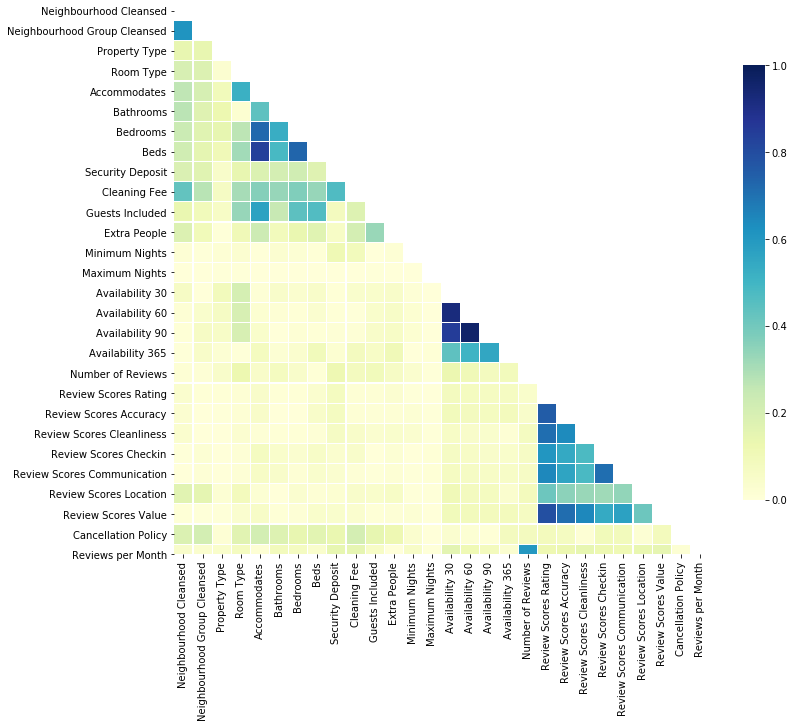

In [21]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Pintemos algunas variables

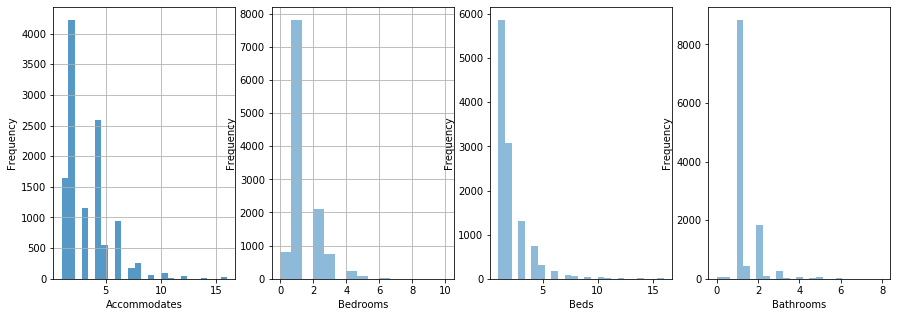

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
train['Accommodates'].plot.hist(alpha=0.75, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,4,2)
train['Bedrooms'].plot.hist(alpha=0.5, bins=15, grid = True)
plt.xlabel('Bedrooms')

plt.subplot(1,4,3)
train['Beds'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Beds')

plt.subplot(1,4,4)
train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Bathrooms')

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month
5. **Neighbourhood Cleansed y Neighbourhood Group Cleansed** muestran una fuerte correlacion, pero de momento dejamos las dos para analizar mediante el filtrado de caracterisdtcas cual de las dos influye mas en la regresion que tenemos que plantear.

In [23]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11824, 16)

## Separacion variable dependiente 
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [24]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


El siguiente paso es aplicar los metodos de filtrados para regresion, pero esto solo se pueden aplicar sobre variables que no contienen valores NaN.
por tanto analicemos que variables tienen valores NaN y llevemos a cabo el proceso de imputacion, aprovechare para analizar algun posible outlier

Para hacerlo vamos a aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(X_train['campo'].unique()))
print(X_train['campo'].isna().sum())
print(X_train['campo'].value_counts())

```

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media (1.3)
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos la media (32)
- Review Scores Rating (2651). Imputamos la mediana (77) ya que la media esta demasiado cerca de la mejor puntuacion.

In [25]:
X_train.drop('Security Deposit', axis=1, inplace=True)

In [26]:
X_train['Bathrooms'] = train['Bathrooms'].fillna(1.3)
X_train['Cleaning Fee'] = train['Cleaning Fee'].fillna(32)
X_train['Review Scores Rating'] = train['Review Scores Rating'].fillna(77)

## Variable objetivo
Por ultimo analizamos la variable objetivo

In [27]:
y_train.describe()

count    11824.000000
mean        73.703146
std         72.161085
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

In [28]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

347
0
50.0     513
60.0     441
30.0     437
25.0     433
35.0     381
        ... 
356.0      1
252.0      1
154.0      1
222.0      1
434.0      1
Name: Price, Length: 347, dtype: int64
73.70314614343708


## Filtrado para regresion
Con las 13 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [29]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

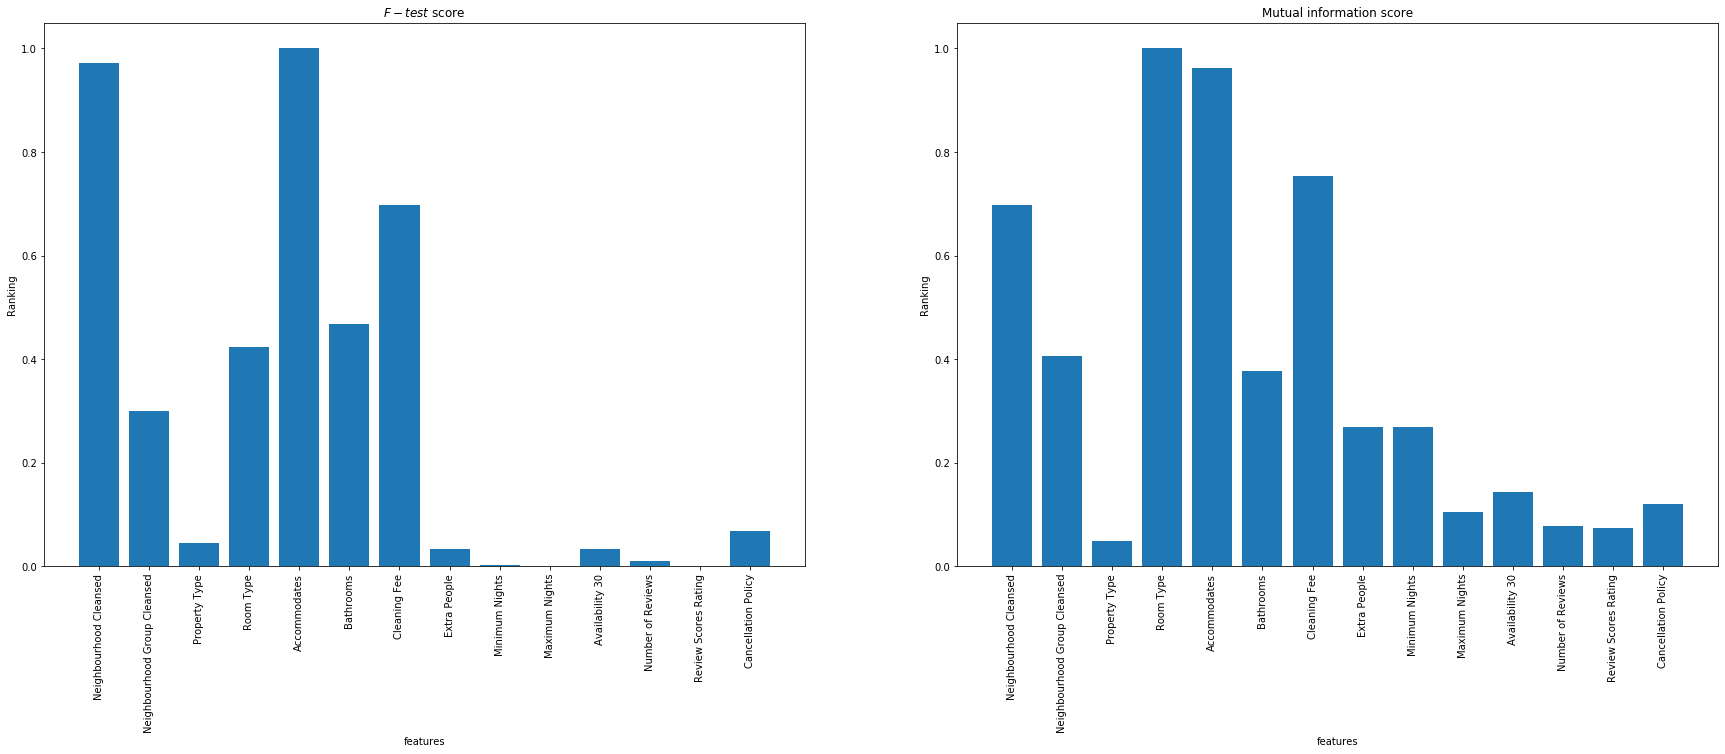

In [30]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Cleansed
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee

Como era de esperar el barrio, el tipo de habitacion y las personas que pueden ocupar la casa son los parametros que mas afectan al precio de la casa.

**Me gustaria apuntar aqui que inicialmente habia hecho una prueba haciendo limpieza de la varibale "Neighbourhood Cleansed" poniendo en la categoria 'Others' todos aquellos barrios por debajo de una frecuencia determinada y la influencia de esa variable era mucho menor**

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [31]:
drop_filtrado = ['Neighbourhood Group Cleansed', 'Property Type', 'Extra People', 'Minimum Nights', 'Maximum Nights', 
                 'Availability 30', 'Number of Reviews', 'Review Scores Rating', 'Cancellation Policy']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [32]:
X_train.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)

In [33]:
X_train.describe()

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee
count,11824.000000,11824.000000,11824.000000,11824.000000,11824.000000
mean,73.703146,73.703146,3.276641,1.286494,32.089648
std,37.714257,27.069322,2.106127,0.666088,24.586216
min,16.000000,31.692308,1.000000,0.000000,0.000000
25%,59.843750,40.334746,2.000000,1.000000,20.000000
50%,67.610954,95.442790,3.000000,1.000000,32.000000
75%,82.065898,95.442790,4.000000,1.000000,32.000000
max,999.000000,95.442790,16.000000,8.000000,662.000000


## Normalizacion
Por ultimo llevamos a cabo el escalado mediante StandarEscales
Recordemos que para test deberemos usar el scaler obtenido en train


In [34]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [35]:
X_train

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee
2472,74.807229,40.334746,1,1.0,32.0
12299,85.973992,95.442790,4,1.0,15.0
4024,50.478873,95.442790,7,1.0,32.0
12692,60.557588,40.334746,2,3.0,32.0
11228,58.990991,40.334746,2,1.0,32.0
...,...,...,...,...,...
13123,64.032407,95.442790,3,1.0,16.0
3264,140.529412,95.442790,6,2.5,32.0
9845,77.835414,95.442790,2,1.0,30.0
10799,77.835414,95.442790,2,1.0,25.0


In [36]:
X_train_scaled

array([[ 0.02927618, -1.23275388, -1.08100664, -0.4301317 , -0.00364643],
       [ 0.32537735,  0.80314398,  0.34346929, -0.4301317 , -0.69512001],
       [-0.61582162,  0.80314398,  1.76794521, -0.4301317 , -0.00364643],
       ...,
       [ 0.10957243,  0.80314398, -0.60618133, -0.4301317 , -0.08499627],
       [ 0.10957243,  0.80314398, -0.60618133, -0.4301317 , -0.28837085],
       [-0.99301965,  0.80314398, -0.13135602, -0.4301317 , -0.00364643]])

**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Prueba de Modelos

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el **dataset de Test** con las mismas transformaciones que hemos llevado a cao sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): encoder_room_type y encoder_neigh_group
- Tratamiento de NaNs: Bathroom y Cleaning Fee


Analizamos y limpiamos el dataset de test

In [37]:
test = pd.read_csv('./data/test.csv',sep=';', decimal='.')
test.shape
#test.info()

(2956, 29)

In [38]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(test['Neighbourhood Cleansed'].unique()))
print(test['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(test['Neighbourhood Cleansed'].value_counts())

261
0
Embajadores                                          373
Universidad                                          304
Palacio                                              203
Sol                                                  173
Justicia                                             159
Cortes                                               146
Trafalgar                                             62
Puerta del Angel                                      49
Argüelles                                             48
Palos de Moguer                                       47
Arapiles                                              45
Guindalera                                            44
Goya                                                  39
Delicias                                              33
Recoletos                                             32
Almagro                                               31
Gaztambide                                            31
Acacias                  

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 29 columns):
Neighbourhood Cleansed          2956 non-null object
Neighbourhood Group Cleansed    2755 non-null object
Property Type                   2956 non-null object
Room Type                       2956 non-null object
Accommodates                    2956 non-null int64
Bathrooms                       2946 non-null float64
Bedrooms                        2949 non-null float64
Beds                            2942 non-null float64
Price                           2953 non-null float64
Security Deposit                1221 non-null float64
Cleaning Fee                    1720 non-null float64
Guests Included                 2956 non-null int64
Extra People                    2956 non-null int64
Minimum Nights                  2956 non-null int64
Maximum Nights                  2956 non-null int64
Availability 30                 2956 non-null int64
Availability 60                 2956 non-null

A la vista de los datos de arriba vemos que Price tienen valores NaN(3), por ello deberemos limpiarlos 

In [40]:
#Dropeamos
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit 
test.drop('Security Deposit', axis=1, inplace=True)

#imputamos los valores NaNs del target con la media del test (No estoy seguro si deberia usar esa media o la del train)
media_target_test = np.mean(test['Price'])
test['Price'] = test['Price'].fillna(media_target_test)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(1.3)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(32)


#Aplicamos el Mean Encoder a Room Type y a Neighbourhood Cleansed (En este caso entiendo que debemos usar sus propios datos 
# y no los de train, porque salen de la relacion entre la variable en target)
mean_encode_room_type_test = test.groupby('Room Type')['Price'].mean()
mean_encode_neigh_test = test.groupby('Neighbourhood Cleansed')['Price'].mean()
test.loc[:,'Room Type'] = test['Room Type'].map(mean_encode_room_type_test)
test.loc[:,'Neighbourhood Cleansed'] = test['Neighbourhood Cleansed'].map(mean_encode_neigh_test)


#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)


Separamos la variable objetivo del tets

In [41]:
y_test = test['Price']
X_test= test.drop(['Price'], axis=1)

Normalizamos los datos de Test

In [42]:
X_test_scaled = scaler.fit_transform(X_test)

In [43]:
X_test

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee
0,27.444444,41.436544,1,1.0,5.0
1,59.434316,93.902896,2,1.0,32.0
2,78.322581,93.902896,2,1.0,20.0
3,30.500000,41.436544,1,0.5,32.0
4,59.434316,93.902896,3,1.0,32.0
...,...,...,...,...,...
2951,37.636364,41.436544,1,1.0,32.0
2952,59.434316,93.902896,2,1.0,32.0
2953,26.285714,41.436544,1,1.0,32.0
2954,83.381503,93.902896,5,1.5,40.0


In [44]:
X_test_scaled

array([[-1.01173018, -1.21370811, -1.10715781, -0.42388564, -1.33165187],
       [-0.30121825,  0.80401619, -0.62208912, -0.42388564,  0.04753863],
       [ 0.11830006,  0.80401619, -0.62208912, -0.42388564, -0.56543493],
       ...,
       [-1.03746618, -1.21370811, -1.10715781, -0.42388564,  0.04753863],
       [ 0.23066139,  0.80401619,  0.83311697,  0.38190597,  0.45618767],
       [-0.56469925,  0.80401619,  1.31818567,  1.18769758,  0.45618767]])

## Lasso Model

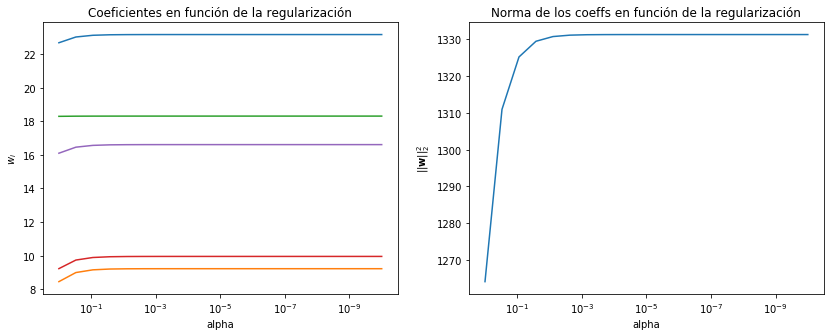

In [45]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

n_alphas = 20
alphas = np.logspace(-10, 0, n_alphas)

coefs = []

norm2_coefs = []
for a in alphas:
    #### TU CÓDIGO AQUÍ
    lasso = Lasso(alpha = a).fit(X_train_scaled,y_train)    
    #####
    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()

Valores de alpha: [1.00000000e-10 2.87298483e-10 8.25404185e-10 2.37137371e-09
 6.81292069e-09 1.95734178e-08 5.62341325e-08 1.61559810e-07
 4.64158883e-07 1.33352143e-06 3.83118685e-06 1.10069417e-05
 3.16227766e-05 9.08517576e-05 2.61015722e-04 7.49894209e-04
 2.15443469e-03 6.18965819e-03 1.77827941e-02 5.10896977e-02
 1.46779927e-01 4.21696503e-01 1.21152766e+00 3.48070059e+00
 1.00000000e+01]
best mean cross-validation score: -2577.523
best parameters: {'alpha': 1e-10}


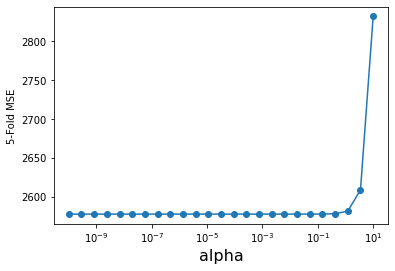

In [46]:
alpha_vector = np.logspace(-10,1,25)
param_grid = {'alpha': alpha_vector }
print(f'Valores de alpha: {alpha_vector}')
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((0, 1))
plt.show()

In [51]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled,y_train)

degree = 6

# predicción
y_hat = lasso.predict(X_test_scaled)
w = lasso.coef_
norm_w2 = np.dot(w,w.T)

# error
error_test = np.mean(np.power(y_test - y_hat,2)) 



print('Grado: %i, MSE:%.2f\nalpha: %g, $||w||_2^2$ = %.2g'%(degree,error_test,alpha_optimo,norm_w2))


coef_names = ['w' + str(i) + ': ' for i in range(1,degree+1)]

for f,wi in zip(coef_names,w):
    print(f,wi)

Grado: 6, MSE:2200.40
alpha: 1e-10, $||w||_2^2$ = 1.3e+03
w1:  23.152221406162678
w2:  9.22916501490629
w3:  18.30381738347222
w4:  9.959589221864697
w5:  16.607833189586763


**No entiendo como me salen estos errores tan horribles!!!**